In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [24]:
def parser(x):
	return pd.datetime.strptime(x, '%Y-%m-%d')

In [25]:
example = parser('1995-01-01')

example

datetime.datetime(1995, 1, 1, 0, 0)

In [26]:
dataset = pd.read_csv('drive/My Drive/BCML/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [27]:
dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

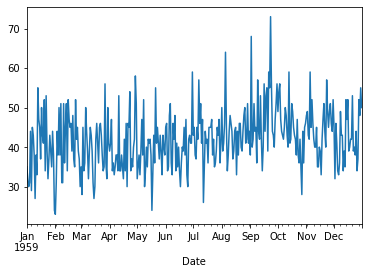

In [28]:
# Jawaban 1 dan 2
dataset.plot()
plt.show()

^ Dataset yang digunakan terdapat No Trend dan No Seasonality didalamnya karena grafik tidak mengalami kenaikan yang signifikan ke atas dan tidak ada pola yang konstan dalam rentang waktu bulan

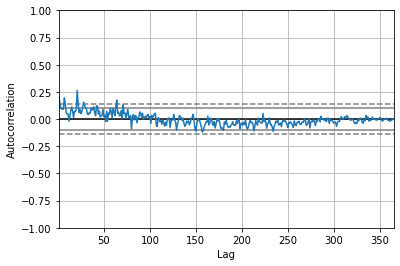

In [29]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

**ARIMA**

In [30]:
# Jawaban 3
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
model = ARIMA(dataset, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                  364
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1231.585
Method:                       css-mle   S.D. of innovations              7.119
Date:                Thu, 17 Sep 2020   AIC                           2487.170
Time:                        07:21:21   BIC                           2533.936
Sample:                    01-02-1959   HQIC                          2505.757
                         - 12-31-1959                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0327      0.077      0.422      0.673      -0.119       0.185
ar.L1.D.Births     -0.7923      0.052    -15.134      0.000      -0.895      -0.690
ar.L2.D.Births     -0.6647      

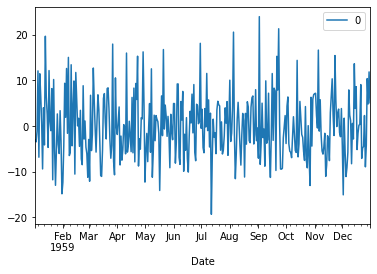

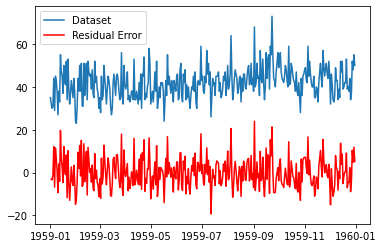

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [ ]:
residuals

,0
Date,
1959-01-02,-3.032694
1959-01-03,-3.431229
1959-01-04,-1.101588
1959-01-05,12.102393
1959-01-06,-6.801179
...,...
1959-12-27,-4.203342
1959-12-28,10.416590
1959-12-29,4.861612


In [ ]:
print(residuals.describe())

                0
count  364.000000
mean     0.008907
std      7.136486
min    -19.303852
25%     -5.265805
50%     -1.034189
75%      4.634802
max     23.980414


In [ ]:
values = dataset.values
size = int(len(values) * 0.66)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	prediction = output[0]
	predictions.append(prediction)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=43.232869, expected=51.000000
predicted=44.247391, expected=41.000000
predicted=43.972229, expected=44.000000
predicted=44.496930, expected=38.000000
predicted=44.348085, expected=68.000000
predicted=48.414286, expected=40.000000
predicted=45.902948, expected=42.000000
predicted=44.209122, expected=51.000000
predicted=47.109689, expected=44.000000
predicted=45.834224, expected=45.000000
predicted=45.289557, expected=36.000000
predicted=46.055339, expected=57.000000
predicted=49.499690, expected=44.000000
predicted=46.034602, expected=42.000000
predicted=45.055139, expected=53.000000
predicted=47.571263, expected=42.000000
predicted=45.844238, expected=34.000000
predicted=43.086619, expected=40.000000
predicted=44.529252, expected=56.000000
predicted=47.437512, expected=44.000000
predicted=44.585054, expected=53.000000
predicted=46.252338, expected=55.000000
predicted=47.659795, expected=39.000000
predicted=43.570465, expected=59.000000
predicted=45.126238, expected=55.000000


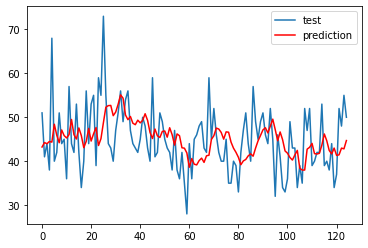

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

In [ ]:
# Grid Search
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = measure_rmse(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [22]:
import warnings

p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=8.189
ARIMA(0, 0, 1) RMSE=7.884
ARIMA(0, 1, 0) RMSE=9.167
ARIMA(0, 1, 1) RMSE=7.527
ARIMA(1, 0, 0) RMSE=7.802
ARIMA(1, 0, 1) RMSE=7.554
ARIMA(1, 1, 0) RMSE=8.120
ARIMA(1, 1, 1) RMSE=7.425
ARIMA(2, 0, 0) RMSE=7.697
ARIMA(2, 0, 1) RMSE=7.421
ARIMA(2, 1, 0) RMSE=7.713
ARIMA(2, 1, 1) RMSE=7.417
ARIMA(3, 0, 0) RMSE=7.693
ARIMA(3, 0, 1) RMSE=7.447
ARIMA(3, 1, 0) RMSE=7.581
ARIMA(3, 1, 1) RMSE=7.456
ARIMA(4, 0, 0) RMSE=7.693
ARIMA(4, 0, 1) RMSE=7.829
ARIMA(4, 1, 0) RMSE=7.578
ARIMA(4, 1, 1) RMSE=7.474
ARIMA(5, 0, 0) RMSE=7.676
ARIMA(5, 0, 1) RMSE=7.638
ARIMA(5, 1, 0) RMSE=7.611
ARIMA(5, 1, 1) RMSE=7.490
ARIMA(6, 0, 0) RMSE=7.666
ARIMA(6, 0, 1) RMSE=7.711
ARIMA(6, 1, 0) RMSE=7.293
ARIMA(6, 1, 1) RMSE=7.554
ARIMA(7, 0, 0) RMSE=7.462
ARIMA(7, 0, 1) RMSE=7.487
ARIMA(7, 1, 0) RMSE=7.527
ARIMA(7, 1, 1) RMSE=7.298
ARIMA(8, 0, 0) RMSE=7.549
ARIMA(8, 0, 1) RMSE=7.565
ARIMA(8, 1, 0) RMSE=7.569
ARIMA(8, 1, 1) RMSE=7.430
ARIMA(9, 0, 0) RMSE=7.561
ARIMA(9, 0, 1) RMSE=7.616
ARIMA(9, 1, 

**SARIMA**

In [31]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [33]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 44.844
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 25.589
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 8.141
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 18.100
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 6.941
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'n']] 7.288
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']] 6.763
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'n']] 6.727
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 7.164
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 6.893
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'n']] 6.763
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'c']] 6.800
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 6.829
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 7.003
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'c']] 6.799
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'c']] 6.875
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'c']] 6.946
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 21.426
 > Model[[(0, 0, 0), (0, 0, 1, 0), 't']] 14.122
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'c']] 6.908
 > Model[[(0, 0, 0), (0, 0, 2, 0), 't']] 11.335
 > Mode

**Jawaban** **5**

ARIMA : (6, 1, 0) RMSE=7.293

Untuk ARIMA terbaik menggunakan hyperparameter p (Autocorrelation) = 6, d(Integrated) = 1, q(Moving Average) = 0

SARIMA : [(1, 0, 2), (1, 0, 2, 0), 't'] RMSE : 6.29936070988945

Untuk SARIMA terbaik menggunakan hyperparameter p (Autocorrelation)= 1, 
d (Integrated)= 0, 
q (Moving Average)= 2, 

P (Seasonal autoregressive order)= 1, 

D (Seasonal difference order)= 0, 

Q (Seasonal moving average order)= 2, 

m (Time steps untuk sebuah seasonal period)= 0 dan 

t(Trend) = 't' (Linear)